<a href="https://colab.research.google.com/github/stevesungkim/DESC-620-Steve-Kim/blob/main/DESC624_LECTURE2_EDA_and_DecisionTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DESC 624 - EDA and Decision Tree Notebook**

This notebook will contain both R and nearly equivalent python code.  

You must use %%R at the top of each notebook block in order for the code to be interpreted as R code. 

"#" before or after code is a comment

If you do not specify %%R at the top of the notebook block, the notebook will interpret the code as Python code.  

You are welcome to use either python and R to do the work.  I will try and apply both R and Python examples as we go through this together.

You MUST use 
"#!pip install rpy2"
"%load_ext rpy2.ipython"

Before any R code is executed. Notice how this block of code does NOT contain a %%R at the top. 

**PLEASE DO NOT EDIT THE NOTEBOOK.  PLEASE MAKE A COPY TO YOUR DRIVE AND MAKE EDITS TO YOUR COPY.**

In [ ]:
#!pip3 install rpy2
%load_ext rpy2.ipython

#**I. Python Setup Section** 

In [ ]:
##Python Packages
import pandas as pd
from sklearn import tree
import pydotplus
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import seaborn as sn
import numpy as np

In [ ]:
#Install python datatable which is the same as data.table() in R
!pip install datatable
import datatable as dt

from datatable import (dt, f, by, ifelse, update, sort,
                       count, min, max, mean, sum, rowsum)

     |████████████████████████████████| 96.9 MB 111 kB/s 


In [ ]:
#Python h2o

#H2o is the Machine Learning package we will be using. It has both an R implementation and a Python implemenation. 
#The h2o.init() is commented out below because we are not going to use it for this lecture.

!apt-get install default-jre
!java -version

! pip install h2o

import h2o

#h2o.init()
#h2o.shutdown()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
openjdk version "11.0.15" 2022-04-19
OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
     |████████████████████████████████| 177.0 MB 12 kB/s 
  Created wheel for h2o: filename=h2o-3.36.1.1-py2.py3-none-any.whl size=177068062 sha256=0e6326adfb299a9aa4632392ee471baec376446e2b16cddd843046bebe38d36b
  Stored in directory: /root/.cache/pip/wheels/a6/d9/ab/5442447c7e2ccf07f66aa8b79f3877ce5382f0b95e6c0c797b
Successfully built h2o


#**II. Python Data Loading**

In [ ]:
#Data Load in Python
bank_p = dt.fread("https://raw.githubusercontent.com/jjghockey/DESC624/main/bank-additional-full.csv")
bank_p.head()

#**III. Python Data Exploration**

Pythons function for summary() only uses numeric values, so you will have to build categorical tables on your own.

In [ ]:
bank_p.names

Categorical tables using python

In [ ]:
bank_p['count'] = 1  #Build a new variable in order to count rows in the data
bank_p[f.y=="yes",'y1']=1
bank_p[f.y=="no",'y1']=0

bank_p[:, sum(f.count), by('y', 'y1')]  #Recode y into a 0/1 dummy variable

In [ ]:
bank_pd=bank_p.to_pandas()
summary = bank_pd.describe()
summary = summary.transpose()
summary

In [ ]:
bank_pd.head()

In [ ]:
bank_p[:, sum(f.count), by('marital') ]  #Summary table of Marital Status

In [ ]:
bank_p[:, sum(f.count), by('job') ] #Summary table of Job 

In [ ]:
bank_p[:, sum(f.count), by('education') ] #Summary table of education 

In [ ]:
bank_p[:, sum(f.count), by('default') ] #Summary table of default

In [ ]:
bank_p[:, sum(f.count), by('housing') ] #Summary table of housing

In [ ]:
bank_p[:, sum(f.count), by('loan') ] #Summary table of loan

In [ ]:
bank_p[:, sum(f.count), by('contact') ] #Summary table of contact 

In [ ]:
bank_p[:, sum(f.count), by('day_of_week') ] #Summary table of month

In [ ]:
bank_p[:, sum(f.count), by('poutcome') ] #Summary table of month

In [ ]:
#Python Correlation Plot
numeric_col = ['y1', 'age', 'contact', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

corr_matrix = bank_pd.loc[:,numeric_col].corr()
print(corr_matrix)
 
#Using heatmap to visualize the correlation matrix
sn.heatmap(corr_matrix, annot=True)

#**IV. Python Data Processing**

In [ ]:
#A. Adjust values based on the review of the data
import numpy as np
bank_pd=bank_p.to_pandas()
bank_pd['pdays'] = bank_pd['pdays'].replace({999: np.NaN})

In [ ]:
bank_pd.head()

In [ ]:
bank_p=dt.Frame(bank_pd)

In [ ]:
bank_p.head()

In [ ]:
bank_p[:, sum(f.count), by('pdays') ] #Summary table of month

In [ ]:
#B. Filter the data
bank_p=bank_p[f.duration>0,:] #See Documentation. Duration = 0 is perfect predictor of outcome variable

In [ ]:
del bank_p[:,'duration']  #Variable should not be considered because we would not know the duration of the call BEFORE the call occurs

In [ ]:
bank_p.names

In [ ]:
#C. Build additional features
from scipy import stats
bank_p[:,'previous_norm'] = stats.zscore(bank_p['previous'])

In [ ]:
from scipy import stats
bank_p[:,'campaign_norm'] = stats.zscore(bank_p['campaign'])

In [ ]:
bank_p[f.age<=18, 'AGE_CAT'] = '<=18'
bank_p[(f.age>18) & (f.age<=24), 'AGE_CAT'] = '18 to 24'
bank_p[(f.age>24) & (f.age<=30), 'AGE_CAT'] = '25 to 30'
bank_p[(f.age>30) & (f.age<=50), 'AGE_CAT'] = '31 to 50'
bank_p[(f.age>50) & (f.age<=65), 'AGE_CAT'] = '51 to 65'
bank_p[f.age>65, 'AGE_CAT'] = '>65'
bank_p[:, sum(f.count), by('AGE_CAT') ] #Summary table of month

In [ ]:
bank_p['JOB_CAT']='Not Management'
bank_p[(f.job=='entrepreneur'), 'JOB_CAT'] = 'Management'
bank_p[(f.job=='management'), 'JOB_CAT'] = 'Management'
bank_p[(f.job=='self-employed'), 'JOB_CAT'] = 'Management'
bank_p[:, sum(f.count), by('JOB_CAT') ] #Summary table of month

In [ ]:
bank_pd=bank_p.to_pandas()
crosstab_01 = pd.crosstab(bank_pd['AGE_CAT'], bank_pd['y'])
crosstab_norm = crosstab_01.div(crosstab_01.sum(1), axis = 0)
print(crosstab_norm)
crosstab_norm.plot(kind='bar', stacked = True)

plt.legend(['Response = No', 'Response = Yes'])
plt.title('Age Category with Response Overlay')
plt.xlabel('Age Cat'); plt.ylabel('Proportion'); plt.show()

In [ ]:
bank_pd=bank_p.to_pandas()
crosstab_01 = pd.crosstab(bank_pd['JOB_CAT'], bank_pd['y'])
crosstab_norm = crosstab_01.div(crosstab_01.sum(1), axis = 0)
crosstab_norm.plot(kind='bar', stacked = True)

plt.legend(['Response = No', 'Response = Yes'])
plt.title('Job Category with Response Overlay')
plt.xlabel('Job Cat'); plt.ylabel('Proportion'); plt.show()

#**V. Python Data Analysis**

In [ ]:
# Creating a dataframe
bank_pd = bank_p.to_pandas()
  
#Convert variables to factor variables for modeling
bank_pd['job'],_=pd.factorize(bank_pd['job'], sort=True)
bank_pd['marital'],_=pd.factorize(bank_pd['marital'], sort=True)
bank_pd['education'],_=pd.factorize(bank_pd['education'], sort=True)
bank_pd['default'],_=pd.factorize(bank_pd['default'], sort=True)
bank_pd['housing'],_=pd.factorize(bank_pd['housing'], sort=True)
bank_pd['loan'],_=pd.factorize(bank_pd['loan'], sort=True)
bank_pd['poutcome'],_=pd.factorize(bank_pd['poutcome'], sort=True)
bank_pd['contact'],_=pd.factorize(bank_pd['contact'], sort=True)

# Creating a dataframe with 80%
# values of original dataframe
bank_pd_trn = bank_pd.sample(frac = 0.8)
  
# Creating dataframe with 
# rest of the 50% values
bank_pd_tst = bank_pd.drop(bank_pd_trn.index)

bank_pd_tst.describe()

In [ ]:
bank_pd_trn.describe()

In [ ]:
bank_pd_trn['age']

In [ ]:
trn=bank_pd_trn.loc[:,['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'campaign', 'previous','poutcome']]
tar=bank_pd_trn.loc[:,['y1']]
tst=bank_pd_tst.loc[:,['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'campaign', 'previous','poutcome']]

In [ ]:
#Graphic of Training / Test Split
#trn['cate'] = 'trn'
#tst['cate'] = 'tst'

#all=pd.concat([trn,tst], ignore_index=True)

#all.groupby(['cate']).size().plot(kind='bar')
#plt.show()

In [ ]:
tar.describe

In [ ]:
trn.describe

In [ ]:
clf = tree.DecisionTreeClassifier() # defining decision tree classifier
clf=clf.fit(trn,tar)

In [ ]:
prediction = clf.predict(tst) #  Run Predictions

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

y=bank_pd_tst.loc[:,['y1']]

fpr, tpr, thresholds = metrics.roc_curve(y, prediction)
accuracy_score(y, prediction)

In [ ]:
metrics.auc(fpr, tpr)

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_curve(fpr, tpr)

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=20, min_samples_leaf = 10, min_samples_split = 10, min_impurity_decrease = 0.001) # defining decision tree classifier
clf=clf.fit(trn,tar)
prediction = clf.predict(tst) #  Run Predictions

In [ ]:
y=bank_pd_tst.loc[:,['y1']]

fpr, tpr, thresholds = metrics.roc_curve(y, prediction)
accuracy_score(y, prediction)

In [ ]:
metrics.auc(fpr, tpr)

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_curve(fpr, tpr)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif

feat_importance = clf.tree_.compute_feature_importances(normalize=True)
feat_importance #Outputs in order of the predictors you listed

In [ ]:
trn.head()

In [ ]:
import statsmodels.tools.tools as stattools
from sklearn.tree import DecisionTreeClassifier, export_graphviz

X_names = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'campaign', 'previous','poutcome']
y_names = ['0','1']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)

tree.plot_tree(clf,feature_names = X_names, class_names=y_names, filled = True)

#**I. R Setup Sections**

In [ ]:
%%R
#I. Setup ---------------------------------------------------

#Load Packages

a <- installed.packages()
pkgs <- rownames(a)


#Packages used in today's examples:
if("tidyverse" %in% pkgs == FALSE){
  install.packages("tidyverse")
}
if("stringr" %in% pkgs == FALSE){
  install.packages("stringr")
}
if("ggplot2" %in% pkgs == FALSE){
  install.packages("ggplot2")
}
if("ggExtra" %in% pkgs == FALSE){
  install.packages("ggExtra")
}
if("directlabels" %in% pkgs == FALSE){
  install.packages("directlabels")
}
if("data.table" %in% pkgs == FALSE){
  install.packages("data.table")
}
if("ROCR" %in% pkgs == FALSE){
  install.packages("ROCR")
}
if("GGally" %in% pkgs == FALSE) {
  install.packages("GGally")
}
if("gridExtra" %in% pkgs == FALSE) {
  install.packages("gridExtra")
}
if("grid" %in% pkgs == FALSE) {
  install.packages("grid")
}
if("rpart.plot" %in% pkgs == FALSE) {
  install.packages("rpart.plot")
}
if("rpart" %in% pkgs==FALSE) {
  install.packages("rpart")  
}

require(tidyverse)
require(stringr)
require(ggplot2)
require(ggExtra)
require(directlabels)
require(data.table)
require(ROCR)
require(GGally)
require(gridExtra)
require(grid)
require(rpart)
require(rpart.plot)


(as ‘lib’ is unspecified)





































































	‘/tmp/Rtmpxp5VE6/downloaded_packages’

(as ‘lib’ is unspecified)














	‘/tmp/Rtmpxp5VE6/downloaded_packages’

(as ‘lib’ is unspecified)





























	‘/tmp/Rtmpxp5VE6/downloaded_packages’

(as ‘lib’ is unspecified)



















	‘/tmp/Rtmpxp5VE6/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpxp5VE6/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpxp5VE6/downloaded_packages’



✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2

✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()





Attaching package: ‘data.table’



    between, first, last



    transpose




  method from   
  +.gg   ggplot2


Attaching package: ‘gridExtra’



    combine







In [ ]:
%%R

#H2o is the Machine Learning package we will be using. It has both an R implementation and a Python implemenation. 
#The h2o.init() is commented out below because we are not going to use it for this lecture

install.packages("h2o")
require(h2o)

#h2o.init()

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/h2o_3.36.0.4.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 609611 bytes (595 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

#**II. R Data Loading**

You can use the lines of code to read in the raw data directly from a zip file from the UCI Machine Learning Repository.

I am going to help you with this for other data files we will look at together. 


fread() is a general purpose processing tool that converts ASCII character text files into an R data object. 

In [ ]:
%%R
#II. Data Loading ---------------------------------------------

#If the UCI Machine Repo is down this will not work. Use Code in the next block

#url <-"https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"

#temp <- tempfile()
#temp2 <- tempfile()

#download.file(url, temp)
#unzip(zipfile = temp, exdir = temp2)
#bank <- fread(file.path(temp2, "bank-additional/bank-additional-full.csv"), stringsAsFactors=TRUE)

#unlink(c(temp, temp2))

#head(bank)

Alternatively, I have put certain files in my github as raw .csv files.  

fread() can be used to process these directly. 

In [ ]:
%%R
bank <- fread("https://raw.githubusercontent.com/jjghockey/DESC624/main/bank-additional-full.csv", stringsAsFactors=TRUE)
head(bank)

 [0%] Downloaded 1378 bytes...
 [0%] Downloaded 2756 bytes...
 [1%] Downloaded 4134 bytes...
 [1%] Downloaded 5512 bytes...
 [1%] Downloaded 6890 bytes...
 [2%] Downloaded 8268 bytes...
 [2%] Downloaded 9646 bytes...
 [2%] Downloaded 11024 bytes...
 [3%] Downloaded 12402 bytes...
 [3%] Downloaded 13780 bytes...
 [3%] Downloaded 15158 bytes...
 [4%] Downloaded 15496 bytes...
 [8%] Downloaded 31880 bytes...
 [12%] Downloaded 48264 bytes...
 [16%] Downloaded 64648 bytes...
 [21%] Downloaded 81032 bytes...
 [25%] Downloaded 97416 bytes...
 [29%] Downloaded 113800 bytes...
 [34%] Downloaded 130184 bytes...
 [38%] Downloaded 146568 bytes...
 [42%] Downloaded 162952 bytes...
 [47%] Downloaded 179336 bytes...
 [51%] Downloaded 195720 bytes...
 [55%] Downloaded 212104 bytes...
 [60%] Downloaded 228488 bytes...
 [64%] Downloaded 244872 bytes...
 [68%] Downloaded 261256 bytes...
 [72%] Downloaded 277640 bytes...
 [77%] Downloaded 294024 bytes...
 [81%] Downloaded 310408 bytes...
 [85%] Downloaded

   age       job marital   education default housing loan   contact month
1:  56 housemaid married    basic.4y      no      no   no telephone   may
2:  57  services married high.school unknown      no   no telephone   may
3:  37  services married high.school      no     yes   no telephone   may
4:  40    admin. married    basic.6y      no      no   no telephone   may
5:  56  services married high.school      no      no  yes telephone   may
6:  45  services married    basic.9y unknown      no   no telephone   may
   day_of_week duration campaign pdays previous    poutcome emp.var.rate
1:         mon      261        1   999        0 nonexistent          1.1
2:         mon      149        1   999        0 nonexistent          1.1
3:         mon      226        1   999        0 nonexistent          1.1
4:         mon      151        1   999        0 nonexistent          1.1
5:         mon      307        1   999        0 nonexistent          1.1
6:         mon      198        1   999      

#**III. R Data Exploration**

In [ ]:
%%R
#III. Data Exploration -----------------------------------------
#A. File Structure
str(bank)
#B. Basic Summary 
summary(bank)


Classes ‘data.table’ and 'data.frame':	41188 obs. of  21 variables:
 $ age           : int  56 57 37 40 56 45 59 41 24 25 ...
 $ job           : Factor w/ 12 levels "admin.","blue-collar",..: 4 8 8 1 8 8 1 2 10 8 ...
 $ marital       : Factor w/ 4 levels "divorced","married",..: 2 2 2 2 2 2 2 2 3 3 ...
 $ education     : Factor w/ 8 levels "basic.4y","basic.6y",..: 1 4 4 2 4 3 6 8 6 4 ...
 $ default       : Factor w/ 3 levels "no","unknown",..: 1 2 1 1 1 2 1 2 1 1 ...
 $ housing       : Factor w/ 3 levels "no","unknown",..: 1 1 3 1 1 1 1 1 3 3 ...
 $ loan          : Factor w/ 3 levels "no","unknown",..: 1 1 1 1 3 1 1 1 1 1 ...
 $ contact       : Factor w/ 2 levels "cellular","telephone": 2 2 2 2 2 2 2 2 2 2 ...
 $ month         : Factor w/ 10 levels "apr","aug","dec",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ day_of_week   : Factor w/ 5 levels "fri","mon","thu",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ duration      : int  261 149 226 151 307 198 139 217 380 50 ...
 $ campaign      : int  1 1 1 1 1 1 1 1 1 1

ggpairs produces all pairwise comparisons for all variables listed.  

Variables that are listed must be in either numeric format or factor format.  

Factor format is a special R format that treats categorical variables as numeric dummy variables. 

I have commented out this code because it takes a long time to run.  Be cautious when executing ggpairs with many categorical variables. 

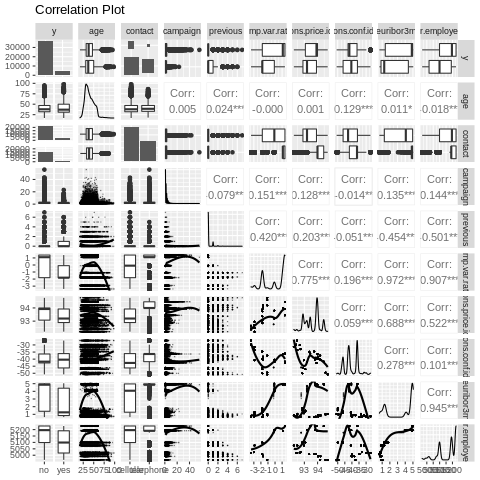

In [ ]:
%%R
#Correlation Plot - This will take awhile, so it is commentted out. 
ggpairs(bank[, .(y, age, contact, campaign, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed)]
			   , lower=list(continuous=wrap("smooth_loess", alpha=0.3, size=0.1, se=FALSE), combo="box", discrete="facetbar"), cardinality_threshold = 20
			   , title="Correlation Plot"
			   )

#**IV. R Data Processing**

You can adjust existing variables or make new ones. 

You will have to do some of this on your own.  The basic code in R is the following: 

object[i,j,k]

i = filter

j = equation

k = grouping statement 


:= is a special operator that means equal

bank[pdays==999, pdays:=NA] does the following: 

whenever the bank object has an observation in the pdays column equal to 999 it changes it to NA

NA is Rs special character for missing value. For example, it is equivalent to NULL in SQL.

The second command in this block performs a filter and overwrites the bank object after the code is executed. The <- is equivalent to an equal sign and in this case, the bank object is re-directed to itself after the filter is applied. 


In [ ]:
%%R
#IV. Data Processing --------------------------------------------
#A. Adjust values based on the review of the data
bank[pdays==999, pdays:=NA]  #Documentation indicates that 999 is a missing value code.

#B. Filter the data
bank<-bank[duration>0,] #See Documentation. Duration = 0 is perfect predictor of outcome variable
bank[, duration:=NULL]  #Variable should not be considered because we would not know the duration of the call BEFORE the call occurs

#C. Build additional features
bank[, previous_norm:=(previous-mean(previous))/sd(previous)]
bank[, campaign_norm:=(campaign-mean(campaign))/sd(campaign)]


       age         job marital           education default housing loan
    1:  56   housemaid married            basic.4y      no      no   no
    2:  57    services married         high.school unknown      no   no
    3:  37    services married         high.school      no     yes   no
    4:  40      admin. married            basic.6y      no      no   no
    5:  56    services married         high.school      no      no  yes
   ---                                                                 
41180:  73     retired married professional.course      no     yes   no
41181:  46 blue-collar married professional.course      no      no   no
41182:  56     retired married   university.degree      no     yes   no
41183:  44  technician married professional.course      no      no   no
41184:  74     retired married professional.course      no     yes   no
         contact month day_of_week campaign pdays previous    poutcome
    1: telephone   may         mon        1    NA        0 nonexi

In [ ]:
%%R
tbl<-bank[, .N, by=list(contact, y)]
tbl[, pct:=N/sum(N), by=list(contact)]
tbl2<-reshape(tbl[, .(N, contact, y)], idvar=c("y"), timevar=c("contact"), direction="wide")
tbl<-reshape(tbl[, .(pct, contact, y)], idvar=c("y"), timevar=c("contact"), direction="wide")
tbl






     y pct.telephone pct.cellular
1:  no    0.94768331     0.852607
2: yes    0.05231669     0.147393


In [ ]:
%%R
#It works now.  It was a simple issue with setting the data as a character 
bank[, job:=as.character(job)]
#bank[, job_type:=NULL]
bank[, .N, job]
bank[job %in% c("management", "entrepreneur", "technician"),job_type:="High Paying"]
bank[job %in% c("blue-collar", "admin.", "housemaid"), job_type:="Low Paying"]
bank[job %in% c("services", "self-employed"), job_type:="Unsure"]
bank[job %in% c("retired", "unknown", "student", "unemployed"), job_type:="Unemployed"]
bank[, job_type:=as.factor(job_type)]
bank[, .N, job_type]


      job_type     N
1:  Low Paying 20733
2:      Unsure  5390
3: High Paying 11122
4:  Unemployed  3939


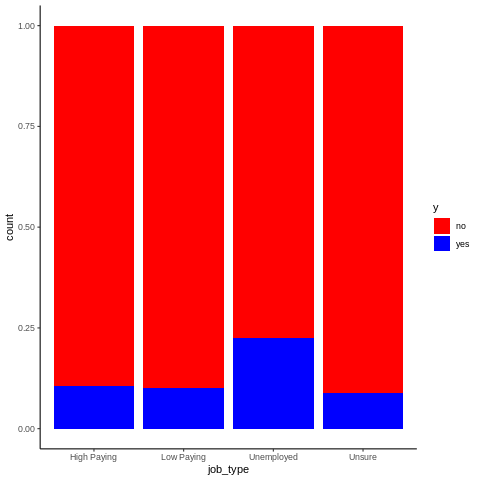

In [ ]:
%%R
plt0<-ggplot(bank, aes(x=job_type, fill=y))+geom_bar(position="fill")+theme_classic()+scale_fill_manual(values=c("red", "blue"))
plt0

In [ ]:
%%R
#bank[, age_cat:=NULL]
bank[age<25, age_cat:="Less than 25"]
bank[age>=25 & age<55, age_cat:="25 to 54"]
bank[age>=55, age_cat:="Greater than or equal to 55"]
bank[, age_cat:=as.factor(age_cat)]
bank[, .N, age_cat]


                       age_cat     N
1: Greater than or equal to 55  4229
2:                    25 to 54 35887
3:                Less than 25  1068


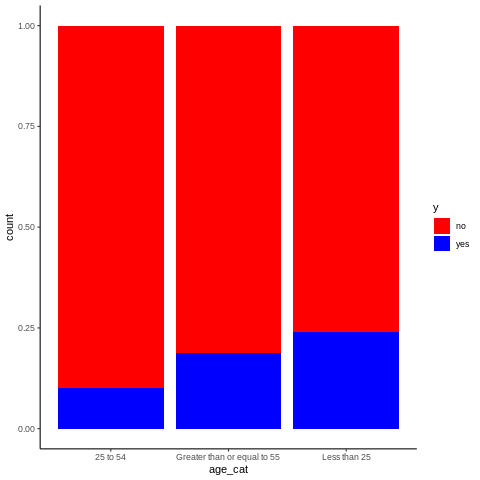

In [ ]:
%%R
plt0<-ggplot(bank, aes(x=age_cat, fill=y))+geom_bar(position="fill")+theme_classic()+scale_fill_manual(values=c("red", "blue"))
plt0

#**V. R Data Analysis**

ggplot() is the best graphics package for R.  It works based on grammar of graphics, which follows the following formula: 

data + variables + shape

ggplot(data, aes(variable))+geom_

data is our data object
variable is your x, or x, y variables
geom_ is your shape.  

In this case you are creating a histogram()



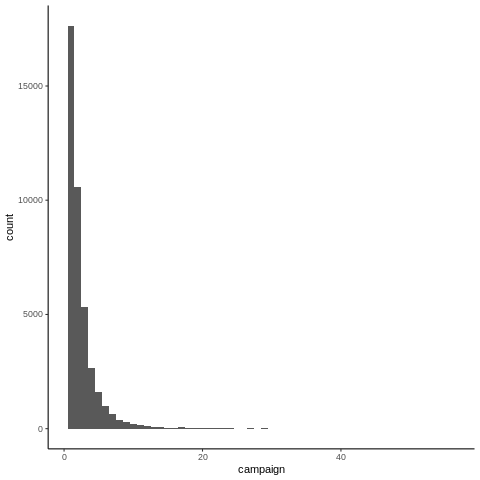

In [ ]:
%%R
#V. Data Analysis ----------------------------------------------
#A. Plotting and EDA
plt1<-ggplot(bank, aes(campaign))+geom_histogram(binwidth=1)+theme_classic()
plt1

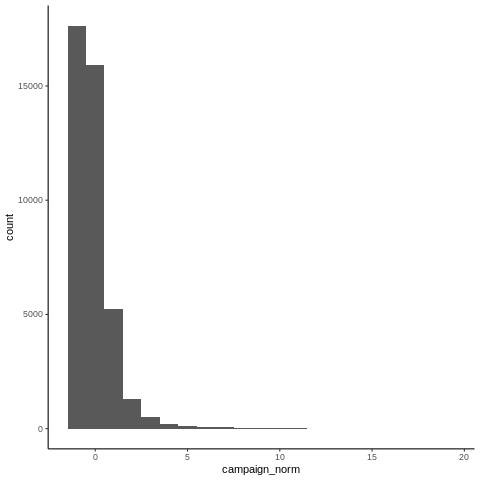

In [ ]:
%%R
plt2<-ggplot(bank, aes(campaign_norm))+geom_histogram(binwidth=1)+theme_classic()
plt2

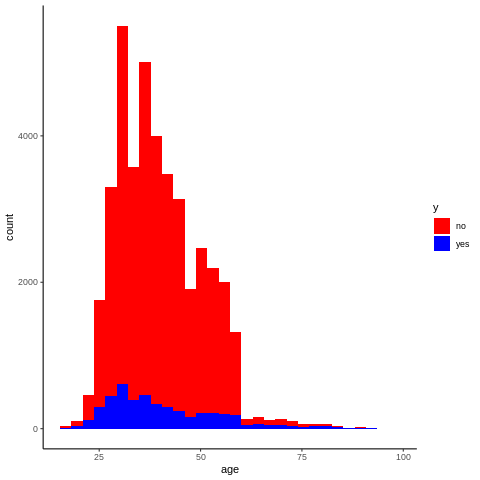

In [ ]:
%%R
plt3<-ggplot(bank, aes(x=age, fill=y))+geom_histogram()+theme_classic()+scale_fill_manual(values=c("red", "blue"))
plt3

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



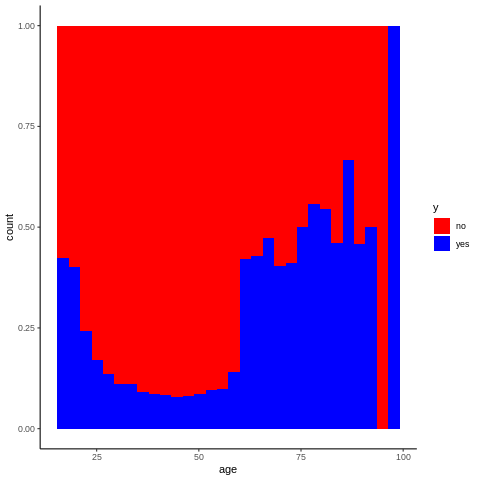

In [ ]:
%%R
plt4<-ggplot(bank, aes(x=age, fill=y))+geom_histogram(position="fill")+theme_classic()+scale_fill_manual(values=c("red", "blue"))
plt4

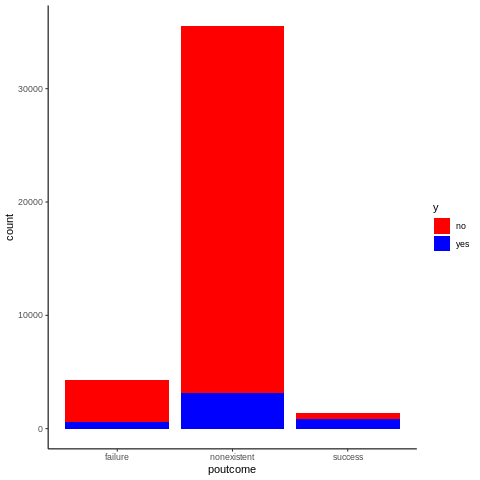

In [ ]:
%%R
plt5<-ggplot(bank, aes(x=poutcome, fill=y))+geom_bar()+theme_classic()+scale_fill_manual(values=c("red", "blue"))
plt5

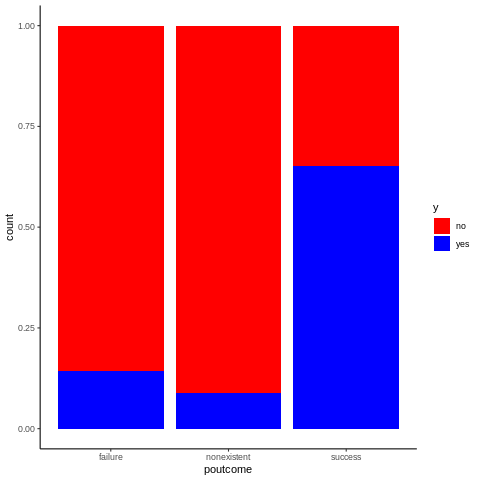

In [ ]:
%%R
plt6<-ggplot(bank, aes(x=poutcome, fill=y))+geom_bar(position="fill")+theme_classic()+scale_fill_manual(values=c("red", "blue"))
plt6

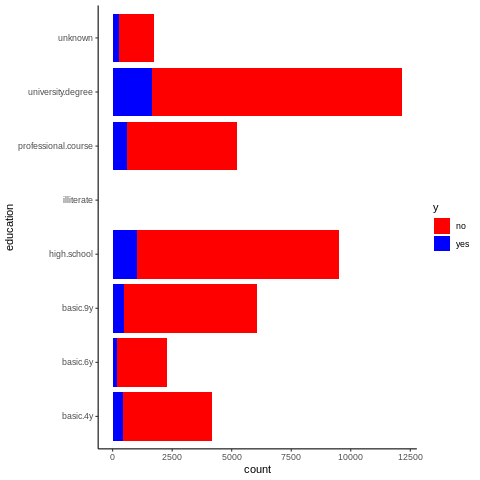

In [ ]:
%%R
plt7<-ggplot(bank, aes(x=education, fill=y))+geom_bar()+theme_classic()+scale_fill_manual(values=c("red", "blue"))+coord_flip()
plt7

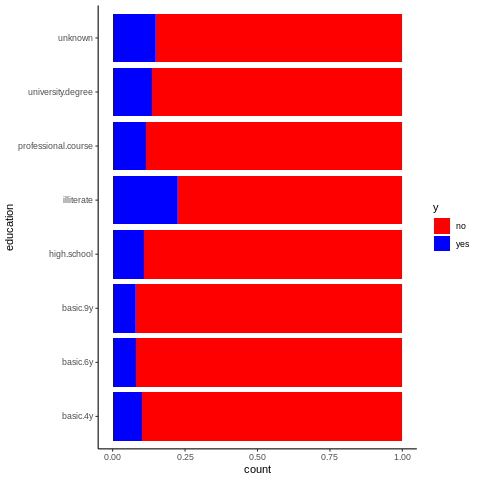

In [ ]:
%%R
plt8<-ggplot(bank, aes(x=education, fill=y))+geom_bar(position="fill")+theme_classic()+scale_fill_manual(values=c("red", "blue"))+coord_flip()
plt8

This is a contingency table that is compared against the response variable "y"

In [ ]:
%%R
tbl<-bank[, .N, by=list(poutcome, y)]
tbl[, pct:=N/sum(N), by=list(poutcome)]
tbl2<-reshape(tbl[, .(N, poutcome, y)], idvar=c("y"), timevar=c("poutcome"), direction="wide")
tbl<-reshape(tbl[, .(pct, poutcome, y)], idvar=c("y"), timevar=c("poutcome"), direction="wide")
tbl

     y pct.nonexistent pct.failure pct.success
1:  no      0.91166793    0.857714   0.3488711
2: yes      0.08833207    0.142286   0.6511289


The r function for a decision tree is rpart() 

R modeling works with formulas, so y~ means model the dependent variable called "y" against the model equation.  

In this case, I am using y~. which means to model y against all other variables.  This is useful if you want to model y against all variables in the data set without having to list them all. 

However, I limit the number of variables being modeled by taking bank_trn and selecting which variables I want to model. 

If you want to adjust the variables in your model add them to the "bank_trn[, .(add variables here)]" part of the command.

method = "class" tells the decision tree to model the data as a classification problem. 

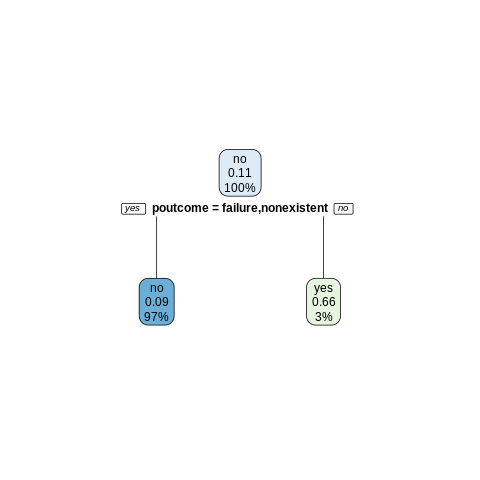

In [ ]:
%%R
#B. Decision Trees
  #1. Randomize the data into Training / Test Sets. Let's use an 80/20% split
  set.seed(1)
  samp<-sample(nrow(bank), size=0.80*nrow(bank))
  bank_trn<-bank[samp]
  bank_tst<-bank[-samp]
  
  #2. Model and Display the Tree
  rpart1<-rpart(y~., bank_trn[, .(y, age, job, marital, education, default
  								, housing, loan, contact
  								, campaign, previous, poutcome)], method="class")
  rpart.plot(rpart1)


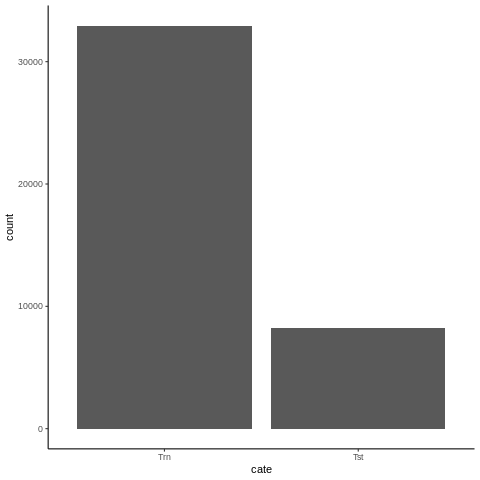

In [ ]:
%%R
#Graphic of Training /Test Split
bank_trn[, cate:="Trn"]
bank_tst[, cate:="Tst"]
bank_all<-rbind(bank_trn, bank_tst)

ggplot(bank_all, aes(cate))+geom_bar()+theme_classic()

In [ ]:
%%R
summary(rpart1)

Call:
rpart(formula = y ~ ., data = bank_trn[, .(y, age, job, marital, 
    education, default, housing, loan, contact, campaign, previous, 
    poutcome)], method = "class")
  n= 32947 

          CP nsplit rel error    xerror       xstd
1 0.09194467      0 1.0000000 1.0000000 0.01552003
2 0.01000000      1 0.9080553 0.9080553 0.01487477

Variable importance
poutcome previous 
      95        5 

Node number 1: 32947 observations,    complexity param=0.09194467
  predicted class=no   expected loss=0.111907  P(node) =1
    class counts: 29260  3687
   probabilities: 0.888 0.112 
  left son=2 (31860 obs) right son=3 (1087 obs)
  Primary splits:
      poutcome splits as  LLR,          improve=665.3807, (0 missing)
      previous < 1.5  to the left,      improve=266.8114, (0 missing)
      age      < 60.5 to the left,      improve=179.8237, (0 missing)
      contact  splits as  RL,           improve=131.4973, (0 missing)
      job      splits as  LLLLLRLLRLLL, improve=126.9288, (0 missing

In [ ]:
%%R
#3. Predict 
 pred1<-predict(rpart1, bank_tst, type="class")
  tbl_dec1<-table(bank_tst$y, pred1)
  tbl_dec1


     pred1
        no  yes
  no  7179  105
  yes  772  181


In [ ]:
%%R
accuracy_Test1 <- sum(diag(tbl_dec1)) / sum(tbl_dec1)
accuracy_Test1  

[1] 0.8935292


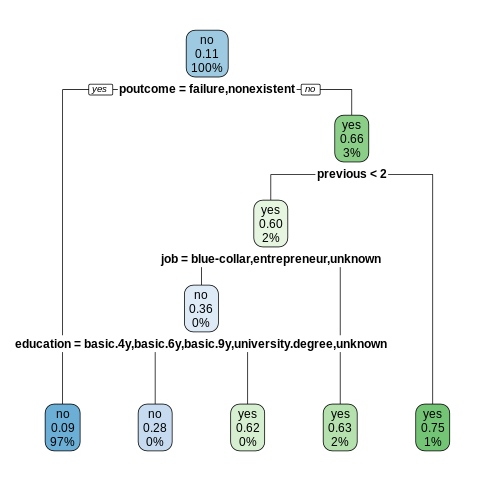

In [ ]:
%%R
#4. Adjust tuning parameters
  cont <- rpart.control(
  	 minsplit = 10,
       minbucket = 10,
       maxdepth = 20,
       cp = 0.001)	
  			
  rpart2<-rpart(y~., bank_trn[, .(y, age, job, marital, education, default
  								, housing, loan, contact
  								, campaign, previous, poutcome)], method="class"
  			, control=cont)
  rpart.plot(rpart2)


In [ ]:
%%R
printcp(rpart2)


Classification tree:
rpart(formula = y ~ ., data = bank_trn[, .(y, age, job, marital, 
    education, default, housing, loan, contact, campaign, previous, 
    poutcome)], method = "class", control = cont)

Variables actually used in tree construction:
[1] education job       poutcome  previous 

Root node error: 3687/32947 = 0.11191

n= 32947 

         CP nsplit rel error  xerror     xstd
1 0.0919447      0   1.00000 1.00000 0.015520
2 0.0032547      1   0.90806 0.90806 0.014875
3 0.0013561      3   0.90155 0.90426 0.014847
4 0.0010000      4   0.90019 0.90561 0.014857


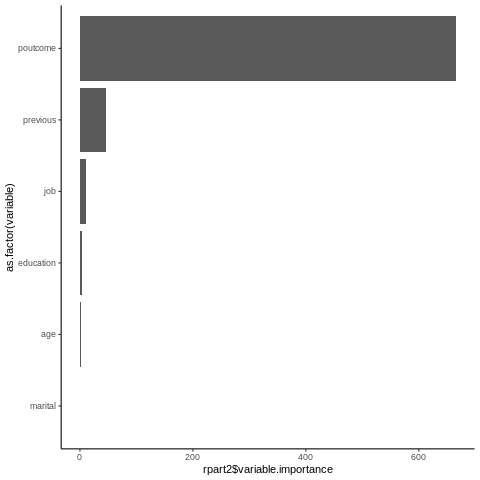

In [ ]:
%%R
#4. Variable importance
var.imp<-as.data.frame(rpart2$variable.importance)
var.imp$variable<-row.names(var.imp)
var.imp<-as.data.table(var.imp)
var.imp[, variable:=factor(variable, levels=c(var.imp[, .(variable)][order(rpart2$variable.importance)] %>% pull()))]

var.imp_plt2<-ggplot(var.imp, aes(x=as.factor(variable), y=rpart2$variable.importance))+geom_bar(stat="identity")+theme_classic()+coord_flip()
var.imp_plt2

In [ ]:
%%R
#5. Predict 
pred2<-predict(rpart2, bank_tst, type="class")
tbl_dec2<-table(bank_tst$y, pred2)
tbl_dec2

     pred2
        no  yes
  no  7191   93
  yes  783  170


In [ ]:
%%R
accuracy_Test2 <- sum(diag(tbl_dec2)) / sum(tbl_dec2)
accuracy_Test2

[1] 0.8936506


In [ ]:
%%R
#6. ROCR Curve
pred_rocr2<-predict(rpart2, newdata=bank_tst, type="prob")[,2]
pred_rocr2<-prediction(pred_rocr2, labels=as.data.frame(bank_tst$y))
perf2 <- performance(pred_rocr2, "tpr", "fpr")
perf2<-data.table(fpr=perf2@x.values[[1]], tpr=perf2@y.values[[1]])

auc<-performance(pred_rocr2, "auc")
auc<-round(auc@y.values[[1]],2)
auc

[1] 0.59


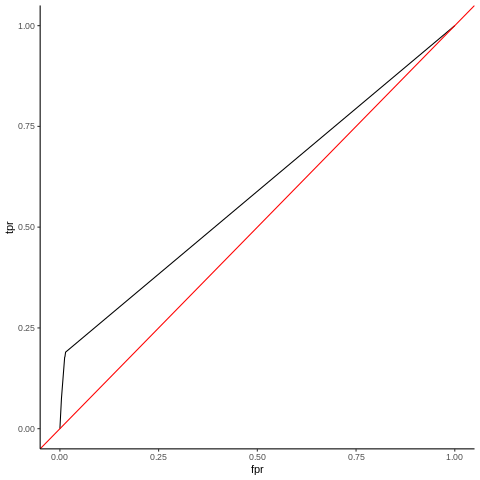

In [ ]:

%%R
rocr2_plt2<-ggplot(perf2, aes(x=fpr, y=tpr))+geom_line()+theme_classic()
rocr2_plt2<-rocr2_plt2+geom_abline(intercept=0, color="red")
rocr2_plt2

[1] 0.0006841068
[1] 0.06416922
[1] 0.1276543
[1] 0.1911394
[1] 0.2546246
[1] 0.3181097
[1] 0.3815948
[1] 0.4450799
[1] 0.508565


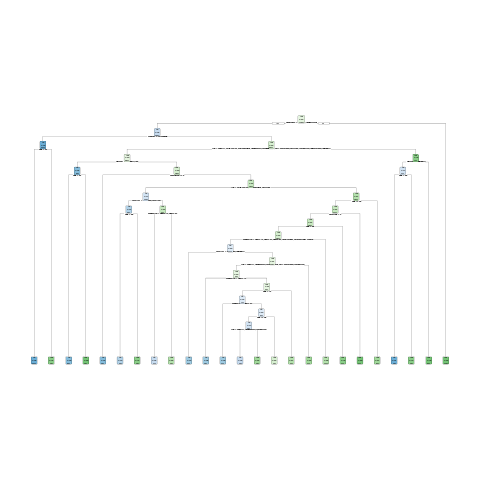

In [ ]:
%%R
#C. Balanced Decision Tree
#1. Normalize Yes to No Samples - Resample match population until distribution of yes / no is approx. 50%
set.seed(1)
samp<-sample(nrow(bank), size=0.80*nrow(bank))
bank_trn<-bank[samp]
bank_tst<-bank[-samp]

bank_y<-bank[y=="yes",]
bank_n<-bank[y=="no"]

i<-0.0
j<-1
while (i < 0.45) {
  set.seed(j)
  tmp<-dplyr::sample_n(bank_y, 50)
if (j==1) {
  out<-tmp
}
else {
  out<-rbind(out,bank_y)
}
  rm(tmp)
  i<- nrow(out)/(nrow(bank_n)*2)
  print(i)
  j<-j+1
}

dta<-rbind(bank_n, out)
rm(out)

#2. Re-run models using balanced datasets
set.seed(1)
samp<-sample(nrow(dta), size=0.80*nrow(dta))
bank_trn<-dta[samp]

  cont <- rpart.control(
  	 minsplit = 10,
       minbucket = 10,
       maxdepth = 20,
       cp = 0.001)	
  			
  rpart3<-rpart(y~., bank_trn[, .(y, age, job, marital, education, default
  								, housing, loan, contact
  								, campaign, previous, poutcome)], method="class"
  			, control=cont)
rpart.plot(rpart3)


In [ ]:
%%R
printcp(rpart3)


Classification tree:
rpart(formula = y ~ ., data = bank_trn[, .(y, age, job, marital, 
    education, default, housing, loan, contact, campaign, previous, 
    poutcome)], method = "class", control = cont)

Variables actually used in tree construction:
[1] age       campaign  contact   default   education job       marital  
[8] poutcome  previous 

Root node error: 29203/58971 = 0.49521

n= 58971 

          CP nsplit rel error  xerror      xstd
1  0.1633736      0   1.00000 1.00000 0.0041576
2  0.0670137      1   0.83663 0.83663 0.0040963
3  0.0256994      2   0.76961 0.76961 0.0040386
4  0.0171900      4   0.71821 0.71462 0.0039763
5  0.0063350      6   0.68383 0.68914 0.0039427
6  0.0038352      7   0.67750 0.68212 0.0039329
7  0.0026025      8   0.67366 0.67633 0.0039247
8  0.0019519      9   0.67106 0.67147 0.0039176
9  0.0017464     10   0.66911 0.66973 0.0039150
10 0.0013526     11   0.66736 0.66894 0.0039139
11 0.0010547     13   0.66466 0.66545 0.0039087
12 0.0010000     24 

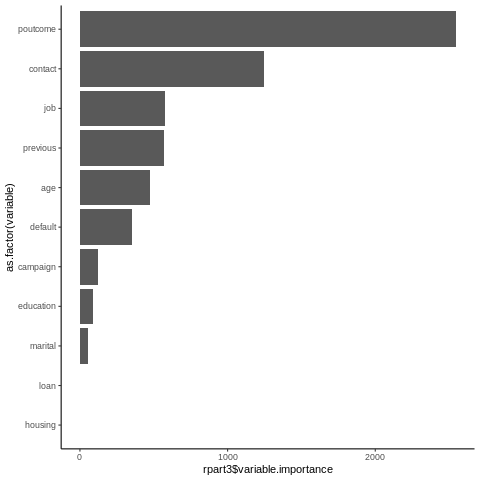

In [ ]:
%%R
#3. Variable Importance
var.imp<-as.data.frame(rpart3$variable.importance)
var.imp$variable<-row.names(var.imp)
var.imp<-as.data.table(var.imp)
var.imp[, variable:=factor(variable, levels=c(var.imp[, .(variable)][order(rpart3$variable.importance)] %>% pull()))]

var.imp_plt3<-ggplot(var.imp, aes(x=as.factor(variable), y=rpart3$variable.importance))+geom_bar(stat="identity")+theme_classic()+coord_flip()
var.imp_plt3

In [ ]:
#4. Predictions
%%R
pred3<-predict(rpart3, bank_tst, type="class")
tbl_dec3<-table(bank_tst$y, pred3)
tbl_dec3

     pred3
        no  yes
  no  5119 2165
  yes  353  600


In [ ]:
%%R
accuracy_Test3 <- sum(diag(tbl_dec3)) / sum(tbl_dec3)
accuracy_Test3

[1] 0.6943062


In [ ]:
%%R
#5. ROCR Curve
pred_rocr3<-predict(rpart3, newdata=bank_tst, type="prob")[,2]
pred_rocr3<-prediction(pred_rocr3, labels=as.data.frame(bank_tst$y))
perf3 <- performance(pred_rocr3, "tpr", "fpr")
perf3<-data.table(fpr=perf3@x.values[[1]], tpr=perf3@y.values[[1]])

auc<-performance(pred_rocr3, "auc")
auc<-round(auc@y.values[[1]],2)
auc

[1] 0.73


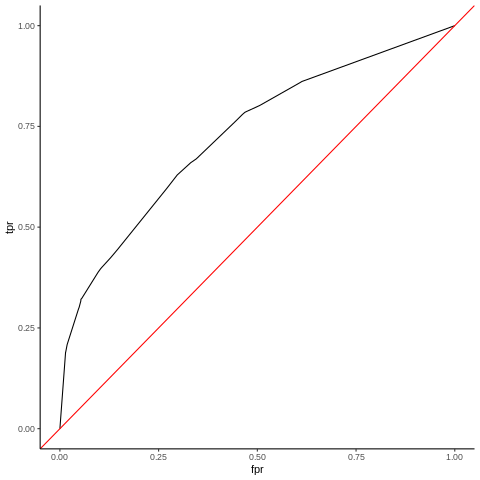

In [ ]:
%%R
rocr3_plt2<-ggplot(perf3, aes(x=fpr, y=tpr))+geom_line()+theme_classic()
rocr3_plt2<-rocr3_plt2+geom_abline(intercept=0, color="red")
rocr3_plt2